In [63]:
%pip install xgboost
%pip install catboost


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.1/99.8 MB 365.7 kB/s eta 0:04:33
   ---------------------------------------- 0.1/99.8 MB 595.3 kB/s eta 0:02:48
   ---------------------------------------- 0.1/99.8 MB 568.9 kB/s eta 0:02:56
   ---------------------------------------- 0.2/99.8 MB 811.5 kB/s eta 0:02:03
   ---------------------------------------- 0.3/99.8 MB 896.4 kB/s eta 0:01:51
   ---------------------------------------- 0.4/99.8 MB 1.1 MB/s eta 0:01:35
   ---------------------------------------- 0.6/99.8 MB 1.4 MB/s eta 0:01:09
   ---------------------------------------- 0.7/99.8 MB 1.6 MB/s eta 0:01:01
   ---------------------------------------- 1.2/99.8 MB 2.3 MB/s eta 0:00:43
    --------------------------------------- 1.3/99.8 MB 2.4 MB/s eta 0:00:41


In [182]:
#получение обучающей, тестовой и тестовой выборки
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import validation_curve, train_test_split
import xgboost as xgb
import catboost as cb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2, l1
from keras import backend as K
import joblib

dbname = 'football'
user = 'postgres'
password = 'TheDarkKhight'
host = 'localhost'
port = 5432

In [3]:
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)

In [108]:
import re, json
def process_row(row):
    fixed_string = re.sub(r'\}\{', ',', all_elo[all_elo['id'] == row['team_id']]['prev_elos'].iloc[0])
    fixed_string = re.sub(r'(\d+)(?=:)', r'"\1"', fixed_string)
    json_string = json.loads(fixed_string)
    return json_string[f"{int(row['time'])}"]

In [109]:
def add_column_elo(frame):
    frame['elo'] = frame.apply(process_row, axis=1)

In [100]:
data_PL23 = pd.read_csv('elo/csv/England/2023/PL.csv')
data_kubokPL23 = pd.read_csv('elo/csv/England/2023/cup.csv')
data_kubokPL23 = data_kubokPL23[data_kubokPL23['home_team_id'].isin(data_PL23['home_team_id'].unique()) & data_kubokPL23['away_team_id'].isin(
                 data_PL23['home_team_id'].unique())]
data_carabaoPL23 = pd.read_csv('elo/csv/England/2023/carabao.csv')
data_carabaoPL23 = data_carabaoPL23[data_carabaoPL23['home_team_id'].isin(data_PL23['home_team_id'].unique()) & data_carabaoPL23['away_team_id'].isin(
                 data_PL23['home_team_id'].unique())]
data_PL23 = data_PL23.merge(data_kubokPL23, how='outer')
data_PL23 = data_PL23.merge(data_carabaoPL23, how='outer')
data_PL23.sort_values('timestamp', inplace=True)
data_PL23.reset_index(inplace=True, drop=True)
data_PL23

,fixtueID,timestamp,home_team_id,home_team_name,home_goals,away_goals,away_team_id,away_team_name
0,1035037,1691780400,44,Burnley,0,3,50,Manchester City
1,1035038,1691839800,42,Arsenal,2,1,65,Nottingham Forest
2,1035039,1691848800,35,Bournemouth,1,1,48,West Ham
3,1035040,1691848800,51,Brighton,4,1,1359,Luton
4,1035041,1691848800,45,Everton,0,1,36,Fulham
...,...,...,...,...,...,...,...,...
126,1035150,1699797600,51,Brighton,1,1,62,Sheffield Utd
127,1035155,1699797600,48,West Ham,3,2,65,Nottingham Forest
128,1035149,1699797600,66,Aston Villa,3,1,36,Fulham
129,1035153,1699797600,40,Liverpool,3,0,55,Brentford


In [101]:
data_RFPL23 = pd.read_csv('elo/csv/Russia/2023/RFPL.csv')
data_kubokRFPL23 = pd.read_csv('elo/csv/Russia/2023/KUBOK.csv')
data_kubokRFPL23 = data_kubokRFPL23[data_kubokRFPL23['home_team_id'].isin(data_RFPL23['home_team_id'].unique()) & data_kubokRFPL23['away_team_id'].isin(
                 data_RFPL23['home_team_id'].unique())]
data_RFPL23 = data_RFPL23.merge(data_kubokRFPL23, how='outer').sort_values('timestamp').reset_index(drop=True)
data_RFPL23.reset_index(inplace=True, drop=True)

In [102]:
all_data = data_PL23.merge(data_RFPL23, how='outer').sort_values('timestamp').reset_index(drop=True)
# 22 год
data_PL22 = pd.read_csv('elo/csv/England/2022/PL.csv')
data_kubokPL22 = pd.read_csv('elo/csv/England/2022/cup.csv')
data_kubokPL22
data_kubokPL22 = data_kubokPL22[data_kubokPL22['home_team_id'].isin(data_PL22['home_team_id'].unique()) & data_kubokPL22['away_team_id'].isin(
                 data_PL22['home_team_id'].unique())]
data_carabaoPL22 = pd.read_csv('elo/csv/England/2022/carabao.csv')
data_carabaoPL22
data_carabaoPL22 = data_carabaoPL22[data_carabaoPL22['home_team_id'].isin(data_PL22['home_team_id'].unique()) & data_carabaoPL22['away_team_id'].isin(
                 data_PL22['home_team_id'].unique())]
data_PL22 = data_PL22.merge(data_kubokPL22, how='outer')
data_PL22 = data_PL22.merge(data_carabaoPL22, how='outer')
data_PL22.sort_values('timestamp', inplace=True)
data_PL22.reset_index(inplace=True, drop=True)

data_RFPL22 = pd.read_csv('elo/csv/Russia/2022/RFPL.csv')
data_kubokRFPL22 = pd.read_csv('elo/csv/Russia/2022/KUBOK.csv')
data_kubokRFPL22 = data_kubokRFPL22[data_kubokRFPL22['home_team_id'].isin(data_RFPL22['home_team_id'].unique()) & data_kubokRFPL22['away_team_id'].isin(
                 data_RFPL22['home_team_id'].unique())]
data_RFPL22 = data_RFPL22.merge(data_kubokRFPL22, how='outer').sort_values('timestamp').reset_index(drop=True)
data_RFPL22.reset_index(inplace=True, drop=True)

In [103]:
#формирование выборки для обучения
general_eng = data_PL22.iloc[100:410].reset_index(drop=True)
general_rus = (data_RFPL22.iloc[80:]).reset_index(drop=True)
all_general = general_eng.merge(general_rus, how='outer')
all_general = all_general.merge(all_data, how='outer')
all_general.sort_values('timestamp').reset_index(drop=True, inplace=True)
all_general

,fixtueID,timestamp,home_team_id,home_team_name,home_goals,away_goals,away_team_id,away_team_name
0,868064,1666204200,40,Liverpool,1.0,0.0,48,West Ham
1,868063,1666204200,34,Newcastle,1.0,0.0,45,Everton
2,868056,1666204200,35,Bournemouth,0.0,1.0,41,Southampton
3,868065,1666206900,33,Manchester United,2.0,0.0,47,Tottenham
4,868060,1666290600,36,Fulham,3.0,0.0,66,Aston Villa
...,...,...,...,...,...,...,...,...
833,1035149,1699797600,66,Aston Villa,3.0,1.0,36,Fulham
834,1035155,1699797600,48,West Ham,3.0,2.0,65,Nottingham Forest
835,1042131,1699804800,2012,PFC Sochi,0.0,2.0,1083,Rubin
836,1035151,1699806600,49,Chelsea,4.0,4.0,50,Manchester City


In [233]:
match_data = pd.read_csv('match_data.csv',index_col='id')

In [234]:
match_data['points'] = match_data.apply(lambda row: 3 if row['goals'] > match_data[(match_data['fixtureID'] == row['fixtureID']) & (match_data['team_id'] != row['team_id'])]['goals'].max() else (0 if row['goals'] < match_data[(match_data['fixtureID'] == row['fixtureID']) & (match_data['team_id'] != row['team_id'])]['goals'].max() else 1), axis=1)

In [236]:
#формирование x и y
def create_samples(data):
    y = []
    x = []
    for _, row in data.iterrows():
        new_line_home = []
        new_line_away = []
        home_team_data = match_data[(match_data['team_id'] == row['home_team_id']) & (match_data['time'] < row['timestamp'])][-10::]
        away_team_data = match_data[(match_data['team_id'] == row['away_team_id']) & (match_data['time'] < row['timestamp'])][-10::]
        points_last_home = match_data[(match_data['team_id'] == row['home_team_id']) & (match_data['time'] < row['timestamp'])][-5::]['points'].sum()
        points_last_away =  match_data[(match_data['team_id'] == row['home_team_id']) & (match_data['time'] < row['timestamp'])][-5::]['points'].sum()
        hh = home_team_data[home_team_data['position'] == 'home']
        ha = home_team_data[home_team_data['position'] == 'away']

        ah = away_team_data[away_team_data['position'] == 'home']
        aa = away_team_data[away_team_data['position'] == 'away']

        new_line_home.extend([row['home_team_id'], row['timestamp'], hh['goals'].mean(), ha['goals'].mean(), hh['shots'].mean(), ha['shots'].mean(), hh['xg'].mean(), ha['xg'].mean(), points_last_home])
        new_line_away.extend([row['away_team_id'], row['timestamp'], ah['goals'].mean(), aa['goals'].mean(), ah['shots'].mean(), aa['shots'].mean(), ah['xg'].mean(), aa['xg'].mean(), points_last_away])

        x.extend([new_line_home, new_line_away]) 
        y.extend([[0.5, min(row['home_goals'], 6) if row['home_goals'] > 0 else 0], [1, min(row['away_goals'], 6) if row['away_goals'] > 0 else 0]])
        #y.extend([[1, row['home_goals']], [2, row['away_goals']]])
    return x, y

In [237]:
x, y = create_samples(all_general)
x = pd.DataFrame(x, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away', 'points'])
y = pd.DataFrame(y, columns=['position', 'actual_goal'])
all_data = pd.concat([x, y], axis=1)
all_data_home = all_data[all_data['position'] == 0.5].reset_index(drop=True)
all_data_away = all_data[all_data['position'] == 1].reset_index(drop=True)
all_data_away

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,points,position,actual_goal
0,48,1666204200,1.20,0.6,4.20,3.6,1.2000,0.600000,8,1.0,0.0
1,45,1666204200,0.60,1.0,3.80,3.6,0.6000,1.000000,9,1.0,0.0
2,41,1666204200,1.20,0.6,6.00,1.4,1.2000,0.600000,9,1.0,1.0
3,47,1666206900,3.00,1.4,8.00,4.2,3.0000,1.400000,10,1.0,0.0
4,66,1666290600,0.80,0.6,3.60,3.8,0.8000,0.600000,4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
833,36,1699797600,1.00,0.8,3.40,4.0,1.2540,0.868000,10,1.0,1.0
834,65,1699797600,1.20,0.6,3.20,3.2,0.9040,0.900000,4,1.0,2.0
835,1083,1699804800,0.40,0.8,2.60,4.0,0.4000,0.962000,7,1.0,2.0
836,50,1699806600,3.75,1.5,5.75,7.5,1.5725,2.096667,10,1.0,4.0


In [238]:
elo_england_22 = pd.read_csv('./elo/csv/England/2022/ratingElo2022_2023PL.csv')
elo_england_23 = pd.read_csv('./elo/csv/England/2023/ratingElo2023_2024PL.csv')

elo_england_22.set_index('id', inplace=True)
elo_england_23.set_index('id', inplace=True)

elo_england_23['prev_elos'] = elo_england_23.apply(lambda row: elo_england_22.loc[row.name]['prev_elos'] + row['prev_elos'] if row.name in elo_england_22.index else row['prev_elos'], axis=1)
elo_england_23.reset_index(inplace=True)

elo_russian_22 = pd.read_csv('./elo/csv/Russia/2022/ratingElo2022_2023RFPL.csv')
elo_russian_23 = pd.read_csv('./elo/csv/Russia/2023/ratingElo2023_2024RFPL.csv')

elo_russian_22.set_index('id', inplace=True)
elo_russian_23.set_index('id', inplace=True)

elo_russian_23['prev_elos'] = elo_russian_23.apply(lambda row: elo_russian_22.loc[row.name]['prev_elos'] + row['prev_elos'] if row.name in elo_russian_22.index else row['prev_elos'], axis=1)
elo_russian_23.reset_index(inplace=True)
all_elo = pd.concat([elo_england_23, elo_russian_23])
all_elo.reset_index(inplace=True)

In [239]:
samples = [all_data_home, all_data_away]
for item in samples:
    add_column_elo(item)
all_data_home['diff_elo'] = all_data_home['elo'] - all_data_away['elo']
all_data_away['diff_elo'] = all_data_away['elo'] - all_data_home['elo']
all_data_home.corr()

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,points,position,actual_goal,elo,diff_elo
team_id,1.000000,-0.014123,-0.213761,-0.206240,-0.234032,-0.239806,-0.242293,-0.216782,-0.266217,NaN,-0.135138,-0.768986,-0.239557
time,-0.014123,1.000000,-0.073592,0.028170,-0.164071,-0.070937,-0.071587,0.070119,-0.021009,NaN,0.002176,0.031675,-0.002928
mean_goals_home,-0.213761,-0.073592,1.000000,0.356721,0.672421,0.377011,0.899050,0.321414,0.550033,NaN,0.178664,0.442607,0.475847
mean_goals_away,-0.206240,0.028170,0.356721,1.000000,0.293140,0.635091,0.354809,0.903990,0.528136,NaN,0.212960,0.361586,0.413023
shots_home,-0.234032,-0.164071,0.672421,0.293140,1.000000,0.376118,0.732573,0.273248,0.460050,NaN,0.181074,0.390572,0.374195
shots_away,-0.239806,-0.070937,0.377011,0.635091,0.376118,1.000000,0.396804,0.638923,0.434207,NaN,0.222045,0.365056,0.386435
xg_home,-0.242293,-0.071587,0.899050,0.354809,0.732573,0.396804,1.000000,0.342100,0.551787,NaN,0.166924,0.450697,0.454936
xg_away,-0.216782,0.070119,0.321414,0.903990,0.273248,0.638923,0.342100,1.000000,0.498130,NaN,0.214902,0.369505,0.406895
points,-0.266217,-0.021009,0.550033,0.528136,0.460050,0.434207,0.551787,0.498130,1.000000,NaN,0.182803,0.507013,0.489543
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
# Разобьем данные на train / valid
x_home = all_data_home.drop(['time','position' ,'actual_goal', 'elo'], axis=1)
x_away = all_data_away.drop(['time','position' ,'actual_goal', 'elo'], axis=1)
scaler_home = MinMaxScaler()
scaler_away = MinMaxScaler()
#scaler = StandardScaler()
x_home = scaler_home.fit_transform(x_home)
x_away = scaler_away.fit_transform(x_away)
joblib.dump(scaler_home, 'scaler_home.save')
joblib.dump(scaler_away, 'scaler_away.save')

x_train_home, x_valid_home = train_test_split(
    x_home, train_size=0.7, shuffle=True, random_state=1,
)
y_train_home, y_valid_home = train_test_split(
    all_data_home["actual_goal"], train_size=0.7, shuffle=True, random_state=1,
)

x_train_away, x_valid_away = train_test_split(
    x_away, train_size=0.7, shuffle=True, random_state=1,
)
y_train_away, y_valid_away = train_test_split(
    all_data_away["actual_goal"], train_size=0.7, shuffle=True, random_state=1,
)

# Разобьем данные на valid / test

x_valid_home, x_test_home = train_test_split(
    x_valid_home, train_size=0.7, shuffle=True, random_state=1,
)
y_valid_home, y_test_home = train_test_split(
    y_valid_home, train_size=0.7, shuffle=True, random_state=1,
)

x_valid_away, x_test_away = train_test_split(
    x_valid_away, train_size=0.7, shuffle=True, random_state=1,
)
y_valid_away, y_test_away = train_test_split(
    y_valid_away, train_size=0.7, shuffle=True, random_state=1,
)

print("x_train.shape = {} rows, {} cols".format(*x_train_home.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid_home.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test_home.shape))

x_train.shape = 586 rows, 9 cols
x_valid.shape = 176 rows, 9 cols
x_test.shape = 76 rows, 9 cols


In [149]:
def get_graphics_goals(y_test, y_pred, msg):
    print(y_test, y_pred)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(msg)
    plt.legend()
    plt.show()

In [58]:
from typing import Tuple
def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (8, 8)
                          ):
    """
    Визуализация процесса настройки гиперпараметра
    алгоритма машинного обучения. Визуализируется значение
    метрики качества на обучащей и тестовой части данных, на
    валидационной части данных и доверительные интервалы.

    Parameters
    ----------
    train_scores: np.array
        Значения метрики качества на обучающей выборке.

    valid_scores: np.array
        Значения метрики качества на валидационной выборке.

    """
    fig = plt.figure(figsize=figsize)

    #plt.subplot(121)
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot(121)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("mae", size=15)
    plt.show()

In [203]:
def get_results_models(models, x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away):
    results_home = {}
    results_away = {}
    results_overall = {}

    results_home_test = {}
    results_away_test = {}
    results_overall_test = {}
    for model in models:
        model_name = model.__class__.__name__
        model_home = model.fit(x_train_home, y_train_home)
        y_pred_home = model_home.predict(x_valid_home)
        y_pred_home_test = model_home.predict(x_test_home)
        mse_home = mean_squared_error(y_valid_home, y_pred_home)
        mae_home = mean_absolute_error(y_valid_home, y_pred_home)
        mse_home_test = mean_squared_error(y_test_home, y_pred_home_test)
        mae_home_test = mean_absolute_error(y_test_home, y_pred_home_test)

        model_away = model.fit(x_train_away, y_train_away)
        y_pred_away = model_away.predict(x_valid_away)
        y_pred_away_test = model_away.predict(x_test_away)
        mse_away = mean_squared_error(y_valid_away, y_pred_away)
        mae_away = mean_absolute_error(y_valid_away, y_pred_away)
        mse_away_test = mean_squared_error(y_test_away, y_pred_away_test)
        mae_away_test = mean_absolute_error(y_test_away, y_pred_away_test)
        if (model_name == 'Pipeline'):
            joblib.dump(model_home, 'model_poly_home_1.joblib')
            joblib.dump(model_away, 'model_poly_away_1.joblib')
        #подбор оптимальной глубины леса
        if (model_name == 'TestRandomForestRegressor'):
            train_scores, valid_scores = validation_curve(
                    X=x_train_home,
                    y=y_train_home,
                    estimator=model,
                    param_range=range(1, 15),
                    param_name="min_samples_leaf",
                    scoring="neg_mean_absolute_error",
                    n_jobs=1,
                    cv=3,
            )
            plot_validation_curves(
                train_scores, valid_scores
            )
            train_scores, valid_scores = validation_curve(
                    X=x_train_away,
                    y=y_train_away,
                    estimator=model,
                    param_range=range(1, 15),
                    param_name="min_samples_leaf",
                    scoring="neg_mean_absolute_error",
                    n_jobs=1,
                    cv=3,
            )
            plot_validation_curves(
                train_scores, valid_scores
            )        
        results_home[model_name] = {'MSE': mse_home, 'MAE': mae_home, 'MIN': min(y_pred_home), 'MAX': max(y_pred_home)}
        results_away[model_name] = {'MSE': mse_away, 'MAE': mae_away, 'MIN': min(y_pred_away), 'MAX': max(y_pred_away)}
        results_overall[model_name] = {'MSE': (mse_home + mse_away) / 2, 'MAE': (mae_home + mae_away) / 2, 'MIN': min(min(y_pred_home), min(y_pred_away)), 'MAX': max(max(y_pred_home),  max(y_pred_away))}
        #get_graphics_goals(y_valid_home, y_pred_home, model_name)
        #get_graphics_goals(y_valid_away, y_pred_away, model_name)

        results_home_test[model_name] = {'MSE': mse_home_test, 'MAE': mae_home_test, 'MIN': min(y_pred_home_test), 'MAX': max(y_pred_home_test)}
        results_away_test[model_name] = {'MSE': mse_away_test, 'MAE': mae_away_test, 'MIN': min(y_pred_away_test), 'MAX': max(y_pred_away_test)}
        results_overall_test[model_name] = {'MSE': (mse_home_test + mse_away_test) / 2, 'MAE': (mae_home_test + mae_away_test) / 2, 'MIN': min(min(y_pred_home_test), min(y_pred_away_test)), 'MAX': max(max(y_pred_home_test),  max(y_pred_away_test))}

    results_home = pd.DataFrame(results_home)
    results_away = pd.DataFrame(results_away)
    results_overall = pd.DataFrame(results_overall)

    results_home_test = pd.DataFrame(results_home_test)
    results_away_test = pd.DataFrame(results_away_test)
    results_overall_test = pd.DataFrame(results_overall_test)
 
    print('Валидационная выборка:\n')
    print('Метрики для домашнего прогноза:')
    print(results_home)
    print('\nМетрики для гостевого прогноза:')
    print(results_away)
    print('\nОбщие метрики:')
    print(results_overall)
    print('Тестовая выборка:\n')
    print('Метрики для домашнего прогноза:')
    print(results_home_test)
    print('\nМетрики для гостевого прогноза:')
    print(results_away_test)
    print('\nОбщие метрики:')
    print(results_overall_test)

In [162]:
def print_neuron_results(model, x, y, label, label_gra):
    test_loss, test_mae = model.evaluate(x, y)
    y_pred = model.predict(x)
    print(label)
    print(f"Test Loss (MSE): {test_loss}")
    #print(f"Test RMSE: {np.sqrt(test_loss_home)}")
    print(f"Test MAE: {test_mae}")
    print(f"MIN: {min(y_pred)}")
    print(f"MAX: {max(y_pred)}")
    #get_graphics_goals(y, y_pred, label_gra)

In [243]:
def neuron_network(x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away):
    # ------------ Прогнозирование (нейронная сеть) ----------------------------
    def root_mean_squared_error(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
    input_shape = (9, )

    model_away = keras.Sequential([
        keras.layers.Dense(256, input_shape=input_shape, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dense(1)
    ])

    model_home = keras.Sequential([
        keras.layers.Dense(256, input_shape=input_shape, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, input_shape=input_shape, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(64, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='linear', kernel_regularizer=l2(0.01)),
        keras.layers.Dense(1)
    ])


    model_away.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model_home.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    early_stopping_home = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)
    early_stopping_away = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

    train_away = model_away.fit(x_train_away, y_train_away, epochs=1000, shuffle=True, batch_size=32, validation_data=(x_valid_away, y_valid_away), callbacks=[early_stopping_away])
    train_home = model_home.fit(x_train_home, y_train_home, epochs=1000, shuffle=True, batch_size=32, validation_data=(x_valid_home, y_valid_home), callbacks=[early_stopping_home])
    
    history = train_away.history
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # ------------ Результаты (нейронная сеть) -----------------------------
    print('Валидационная выборка:\n')  
    print_neuron_results(model_home, x_valid_home, y_valid_home, 'Домашние прогнозы:', 'Нейросеть (домашние прогнозы)')
    print_neuron_results(model_away, x_valid_away, y_valid_away, 'Гостевые прогнозы:', 'Нейросеть (гостевые прогнозы)')

    print('\nТестовая выборка:\n')  
    print_neuron_results(model_home, x_test_home, y_test_home, 'Домашние прогнозы:', 'Нейросеть (домашние прогнозы)')
    print_neuron_results(model_away, x_test_away, y_test_away, 'Гостевые прогнозы:', 'Нейросеть (гостевые прогнозы)')

    model_home.save('home_model_1.h5');
    model_away.save('away_model_1.h5');

In [220]:
def train_model(x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away):
    # ------------ Прогнозирование (линейная регрессия, случайный лес, полином) -----------------------------
    models = [Ridge(random_state=25,alpha=1.0, max_iter=100000), 
	          RandomForestRegressor(random_state=25, max_depth=2, min_samples_leaf=12, n_estimators=300, min_samples_split=3),
              make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Ridge(random_state=25, alpha=1.0))]
              #xgb.XGBRegressor(random_state=25),
              #cb.CatBoostRegressor(random_state=25)]
    get_results_models(models, x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away)
    
    neuron_network(x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away)
    

In [221]:
x_train_away[0]

array([0.00480769, 0.21978022, 0.10666667, 0.22222222, 0.21443299,
       0.21154914, 0.12307692, 0.4       , 0.56886821])

Валидационная выборка:

Метрики для домашнего прогноза:
        Ridge  RandomForestRegressor  Pipeline
MSE  1.525719               1.529568  1.538208
MAE  0.990095               0.997350  0.990701
MIN  0.657945               0.995557  0.797444
MAX  2.693212               2.577038  2.976342

Метрики для гостевого прогноза:
        Ridge  RandomForestRegressor  Pipeline
MSE  1.368851               1.383002  1.385304
MAE  0.909370               0.907649  0.908304
MIN  0.520548               0.908962  0.631483
MAX  1.870102               1.822329  2.134114

Общие метрики:
        Ridge  RandomForestRegressor  Pipeline
MSE  1.447285               1.456285  1.461756
MAE  0.949733               0.952499  0.949503
MIN  0.520548               0.908962  0.631483
MAX  2.693212               2.577038  2.976342
Тестовая выборка:

Метрики для домашнего прогноза:
        Ridge  RandomForestRegressor  Pipeline
MSE  1.284166               1.274393  1.279562
MAE  0.889506               0.891896  0.88763

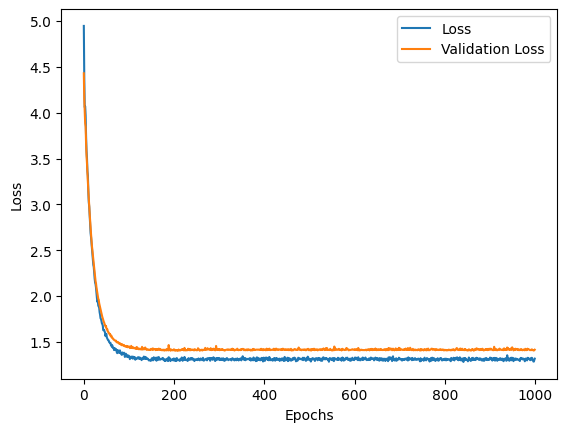

Валидационная выборка:

6/6 [==============================] - 0s 4ms/step
Домашние прогнозы:
Test Loss (MSE): 1.571469783782959
Test MAE: 0.9975752234458923
MIN: [0.78059]
MAX: [2.3478186]
6/6 [==============================] - 0s 4ms/step
Гостевые прогнозы:
Test Loss (MSE): 1.413249135017395
Test MAE: 0.9267991781234741
MIN: [0.8168883]
MAX: [1.7473546]

Тестовая выборка:

3/3 [==============================] - 0s 5ms/step
Домашние прогнозы:
Test Loss (MSE): 1.3336386680603027
Test MAE: 0.8979749083518982
MIN: [0.8903147]
MAX: [2.164248]
3/3 [==============================] - 0s 3ms/step
Гостевые прогнозы:
Test Loss (MSE): 1.3004788160324097
Test MAE: 0.912727952003479
MIN: [0.78665364]
MAX: [1.9250263]


C:\Users\arbol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [244]:
train_model(x_train_home, y_train_home, x_train_away, 
                       y_train_away, x_valid_home, y_valid_home, x_valid_away, y_valid_away, x_test_home, y_test_home, x_test_away, y_test_away)

In [141]:
'''
    Валидационная выборка:
    Для линейной регрессии лучшие показатели - MSE: 1.239810 и MAE: 0.908011. Были при StandardScaller, Ridge(alpha=1.0, max_iter=100000)
    
    Для полиномиальной регрессии лучшие показатели - MSE: 1.250653 и MAE: 0.906175. Были при PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=1.0)

    Для случайного леса лучшие показатели - MSE: 1.246023 и MAE: 0.908439. Были при max_depth=2, min_samples_leaf=12, n_estimators=300, min_samples_split=3

    Нейронная сеть:
    Лучшие показатели - MSE: 1.27825 и MAE: 0.903338. При MinMaxScaler и при регуляризации на всех слоях
    
    Тестовая выборка:
    Для линейной регрессии лучшие показатели - MSE: 1.198250 и MAE: 0.898801.
    
    Для полиномиальной регрессии лучшие показатели - MSE: 1.220643 и MAE: 0.904297.

    Для случайного леса лучшие показатели - MSE: 1.187938 и MAE: 0.897064.

    Нейронная сеть - MSE: 1.15669 и MAE: 0.87002.

'''

'\n    Валидационная выборка:\n    Для линейной регрессии лучшие показатели - MSE: 1.239810 и MAE: 0.908011. Были при StandardScaller, Ridge(alpha=1.0, max_iter=100000)\n    \n    Для полиномиальной регрессии лучшие показатели - MSE: 1.260653 и MAE: 0.906175. Были при PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=1.0)\n\n    Для случайного леса лучшие показатели - MSE: 1.246023 и MAE: 0.908439. Были при max_depth=2, min_samples_leaf=12, n_estimators=300, min_samples_split=3\n\n    Нейронная сеть:\n    Лучшие показатели - MSE: 1.32321703 и MAE: 0.903338. При MinMaxScaler и при регуляризации на всех слоях\n    \n    Тестовая выборка:\n    Для линейной регрессии лучшие показатели - MSE: 1.198250 и MAE: 0.898801.\n    \n    Для полиномиальной регрессии лучшие показатели - MSE: 1.220643 и MAE: 0.904297.\n\n    Для случайного леса лучшие показатели - MSE: 1.187938 и MAE: 0.897064.\n\n    Нейронная сеть - MSE: 1.248805 и MAE: 0.904949.\n\n'

In [142]:
'''
    Проверка случаной модели
'''
y_pred_home_random = np.random.randint(5, size=len(y_valid_home))
y_pred_away_random = np.random.randint(5, size=len(y_valid_away))
y_pred_home_random

array([1, 3, 2, 4, 1, 4, 3, 4, 1, 2, 1, 4, 1, 2, 4, 0, 3, 2, 3, 2, 0, 3,
       1, 4, 3, 1, 1, 0, 3, 4, 4, 0, 1, 2, 4, 0, 3, 3, 4, 4, 0, 3, 1, 1,
       4, 3, 0, 4, 4, 4, 0, 2, 0, 1, 2, 1, 4, 2, 2, 3, 3, 1, 2, 3, 2, 4,
       3, 0, 2, 2, 3, 4, 0, 3, 3, 2, 1, 0, 0, 2, 3, 1, 4, 0, 2, 2, 3, 0,
       2, 2, 1, 4, 1, 4, 1, 1, 2, 0, 3, 4, 2, 3, 1, 2, 4, 0, 2, 4, 0, 3,
       2, 4, 0, 3, 0, 2, 4, 2, 1, 0, 0, 1, 1, 0, 2, 4, 3, 1, 0, 0, 3, 2,
       4, 0, 1, 2, 0, 4, 1, 4, 0, 3, 2, 3, 0, 3, 4, 4, 4, 1, 0, 2, 2, 4,
       1, 3, 3, 2, 2, 1, 0, 2, 3, 4, 1, 4, 4, 3, 0, 3, 4, 4, 3, 3, 1, 2])

In [143]:
mse_random_home = mean_squared_error(y_valid_home, y_pred_home_random)
mae_random_home = mean_absolute_error(y_valid_home, y_pred_home_random)

mse_random_away = mean_squared_error(y_valid_away, y_pred_away_random)
mae_random_away = mean_absolute_error(y_valid_away, y_pred_away_random)

print(f'MSE home: {mse_random_home}')
print(f'MAE home: {mae_random_home}')

print(f'MSE away: {mse_random_away}')
print(f'MAE away: {mae_random_away}')

MSE home: 3.4545454545454546
MAE home: 1.5
MSE away: 3.401360544217687
MAE away: 1.4557823129251701


In [144]:
''' 
    Случайные значения на основе вероятностей в y_train
'''

probabilities_home = [np.sum(y_train_home == 0) / len(y_train_home), 
                      np.sum(y_train_home == 1) / len(y_train_home), 
                      np.sum(y_train_home == 2) / len(y_train_home), 
                      np.sum(y_train_home == 3) / len(y_train_home), 
                      np.sum(y_train_home == 4) / len(y_train_home)]
probabilities_away = [np.sum(y_train_away == 0) / len(y_train_away), 
                      np.sum(y_train_away == 1) / len(y_train_away), 
                      np.sum(y_train_away == 2) / len(y_train_away), 
                      np.sum(y_train_away == 3) / len(y_train_away), 
                      np.sum(y_train_away == 4) / len(y_train_away)]

y_pred_home_prob = np.random.choice([0, 1, 2, 3, 4], size=len(y_valid_home), p=probabilities_home)
y_pred_away_prob = np.random.choice([0, 1, 2, 3, 4], size=len(y_valid_away), p=probabilities_away)
y_pred_away_prob

array([4, 2, 3, 1, 0, 4, 2, 3, 0, 0, 3, 0, 0, 2, 1, 2, 3, 1, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 3, 1, 0, 4, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1,
       0, 1, 0, 1, 0, 1, 3, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 1, 0,
       1, 1, 0, 2, 0, 3, 1, 3, 0, 1, 2, 3, 1, 0, 0, 1, 4, 0, 2, 0, 4, 2,
       2, 0, 2, 0, 4, 1, 4, 1, 1, 4, 0, 1, 3, 1, 3, 2, 1, 2, 0, 1, 2, 4,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 3, 1, 2, 0, 2, 0, 0, 2,
       1, 4, 2, 0, 0, 3, 1, 4, 0, 2, 0, 0, 0, 0, 1])

In [145]:
mse_prob_home = mean_squared_error(y_valid_home, y_pred_home_prob)
mae_prob_home = mean_absolute_error(y_valid_home, y_pred_home_prob)

mse_prob_away = mean_squared_error(y_valid_away, y_pred_away_prob)
mae_prob_away = mean_absolute_error(y_valid_away, y_pred_away_prob)

print(f'MSE home: {mse_prob_home}')
print(f'MAE home: {mae_prob_home}')

print(f'MSE away: {mse_prob_away}')
print(f'MAE away: {mae_prob_away}')

MSE home: 2.727272727272727
MAE home: 1.3295454545454546
MSE away: 3.054421768707483
MAE away: 1.4081632653061225


In [187]:
x_train_home

,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,diff_elo
68,2.200000,1.000000,5.400000,4.200000,2.200000,1.000000,-38.30
76,1.250000,0.333333,4.000000,1.666667,1.250000,0.333333,-211.34
180,0.750000,0.500000,5.250000,3.000000,1.302500,0.685000,-267.63
121,0.833333,1.000000,5.166667,4.000000,0.833333,1.312500,266.67
257,1.800000,0.800000,7.200000,5.400000,2.304000,1.352000,57.52
...,...,...,...,...,...,...,...
715,2.000000,1.333333,5.500000,4.000000,1.547500,1.340000,154.82
767,1.500000,0.750000,4.333333,3.000000,1.678333,0.997500,117.24
72,1.250000,2.166667,5.500000,5.166667,1.250000,2.166667,-82.12
235,1.000000,1.600000,3.200000,4.400000,1.110000,1.104000,162.93
